# Correlation to nuclear segmentation

The `nuclear_correlation` module provides metrics to assess how well cell segmentation masks align with nuclear segmentation masks. It is applicable only when nuclear masks are available.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import spatialdata as sd

sdata = sd.read_zarr("/home/lazic/src/segtraq/tests/data/xenium_sp_subset.zarr")

/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
version mismatch: detected: RasterFormatV02, requested: FormatV04
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 're

In [3]:
sdata

SpatialData object, with associated Zarr store: /g/huber/users/lazic/src/segtraq/tests/data/xenium_sp_subset.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 448, 527), (3, 224, 264), (3, 112, 131), (3, 56, 66), (3, 28, 33)
│     ├── 'if_image': DataTree[cyx] (3, 221, 260), (3, 111, 130), (3, 55, 65), (3, 28, 33), (3, 13, 16)
│     ├── 'morphology_focus': DataTree[cyx] (1, 763, 899), (1, 381, 450), (1, 191, 225), (1, 95, 112), (1, 47, 56)
│     └── 'morphology_mip': DataTree[cyx] (1, 763, 899), (1, 381, 450), (1, 191, 225), (1, 95, 112), (1, 47, 56)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (763, 899), (381, 450), (191, 225), (95, 112), (47, 56)
│     └── 'nucleus_labels': DataTree[yx] (763, 899), (381, 450), (191, 225), (95, 112), (47, 56)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 8) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (158, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (122, 2) (2D shapes)
│ 

In [4]:
sdata["table"].obs.reset_index(inplace=True)

In [5]:
sdata["table"].obs

,index,cell_id,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area,region
0,4612,4613,210,0,0,210,272.066406,27.319531,cell_boundaries
1,4613,4614,192,0,0,192,154.208594,33.280156,cell_boundaries
2,4614,4615,174,0,0,174,170.193906,31.744844,cell_boundaries
3,4615,4616,70,0,0,70,85.796875,26.235781,cell_boundaries
4,4616,4617,85,0,0,85,101.737031,16.843281,cell_boundaries
...,...,...,...,...,...,...,...,...,...
117,80758,80759,227,0,0,227,256.984219,42.221094,cell_boundaries
118,80759,80760,198,0,0,198,222.800938,30.028906,cell_boundaries
119,80760,80761,110,0,0,110,111.355313,33.144688,cell_boundaries
120,80761,80762,150,0,0,150,322.189844,60.644844,cell_boundaries


The `spatialdata`dataset contains cell and nuclear masks as `Shapes`and `Labels`, as shown below.

## Intersection over Union between cell and nucleus masks

First, we compute the Intersection over Union (IoU) between cell and nuclear masks using `compute_cell_nuc_ious`.

In [6]:
import time

import segtraq as st

n = 1

start = time.time()
results_df = st.nc.compute_cell_nuc_ious(sdata, n_jobs=n)
end = time.time()

print(f"Elapsed time with {n} threads: {end - start:.2f} seconds")

Processing IoU between cells and nuclei: 100%|██████████| 158/158 [00:00<00:00, 945.41it/s] 

Elapsed time with 1 threads: 0.17 seconds


For each `cell_id`, we obtain the ID (`best_nuc_id`) of the nucleus mask with the highest `IoU`. If a cell does not overlap with any nucleus, the function returns a missing value for `best_nuc_id`. If the nucleus has an invalid geometry, `IoU`is reported as `NA`.

In [7]:
results_df

,cell_id,best_nuc_id,IoU
0,4613,4613,0.094093
1,4614,4614,0.207238
2,4615,4615,0.178686
3,4616,4616,0.292909
4,4617,4617,0.161824
...,...,...,...
153,80765,None,0.000000
154,80766,None,0.000000
155,80767,None,0.000000
156,80768,None,0.000000


We will store the results in the `.obs` of the `Table` within the `sdata` object for plotting.

In [8]:
sdata["table"]

AnnData object with n_obs × n_vars = 122 × 313
    obs: 'index', 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [9]:
ious_df = results_df.set_index("cell_id")

sdata["table"].obs["IoU"] = sdata["table"].obs["cell_id"].map(ious_df["IoU"])
sdata["table"].obs["best_nuc_id"] = sdata["table"].obs["cell_id"].map(ious_df["best_nuc_id"])

In [10]:
sdata

SpatialData object, with associated Zarr store: /g/huber/users/lazic/src/segtraq/tests/data/xenium_sp_subset.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 448, 527), (3, 224, 264), (3, 112, 131), (3, 56, 66), (3, 28, 33)
│     ├── 'if_image': DataTree[cyx] (3, 221, 260), (3, 111, 130), (3, 55, 65), (3, 28, 33), (3, 13, 16)
│     ├── 'morphology_focus': DataTree[cyx] (1, 763, 899), (1, 381, 450), (1, 191, 225), (1, 95, 112), (1, 47, 56)
│     └── 'morphology_mip': DataTree[cyx] (1, 763, 899), (1, 381, 450), (1, 191, 225), (1, 95, 112), (1, 47, 56)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (763, 899), (381, 450), (191, 225), (95, 112), (47, 56)
│     └── 'nucleus_labels': DataTree[yx] (763, 899), (381, 450), (191, 225), (95, 112), (47, 56)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 8) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (158, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (122, 2) (2D shapes)
│ 

/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:511: UserWarning: Converting `region_key: region` to categorical dtype.
  convert_region_column_to_categorical(table)
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/pytho

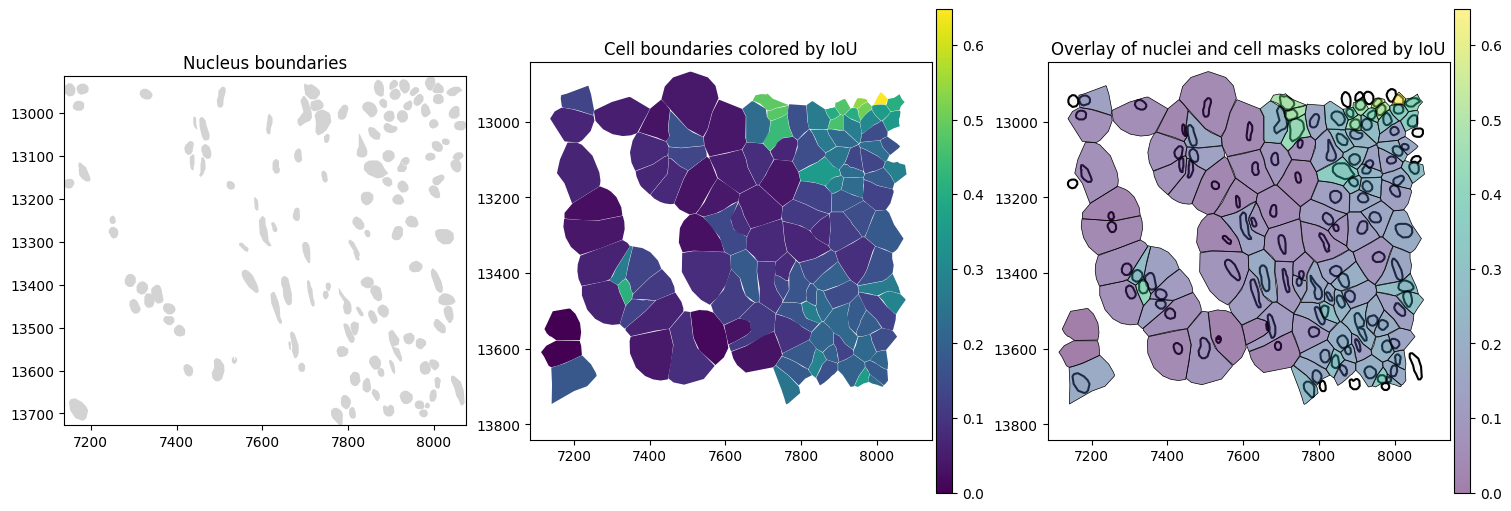

In [11]:
import matplotlib.pyplot as plt

axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)[1].flatten()

# link annotations with cell boundaries
sdata.tables["table"].obs["region"] = "cell_boundaries"
sdata.set_table_annotates_spatialelement("table", region="cell_boundaries")

# plot
sdata.pl.render_shapes("nucleus_boundaries").pl.show(
    ax=axes[0], title="Nucleus boundaries", coordinate_systems="global"
)

sdata.pl.render_shapes("cell_boundaries", color="IoU").pl.show(
    ax=axes[1], title="Cell boundaries colored by IoU", coordinate_systems="global"
)

sdata.pl.render_shapes(
    element="nucleus_boundaries",
    fill_alpha=0.2,
    outline_alpha=1.0,
    outline_color="black",
).pl.render_shapes(
    element="cell_boundaries",
    color="IoU",
    cmap="viridis",
    fill_alpha=0.5,
    outline_alpha=1.0,
    outline_width=0.5,
    outline_color="black",
).pl.show(ax=axes[2], title="Overlay of nuclei and cell masks colored by IoU", colorbar=True)

In the plots above, we can see that cells that have a high overlap with nuclei, also show a high IoU value. Below, we plot a histogram of IoU values and can see that the median IoU is at 0.16, i.e. 16% overlap. 

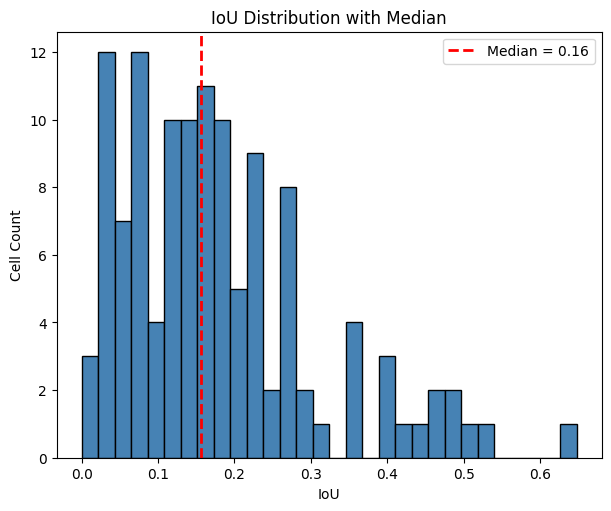

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare IoU values
ious = sdata["table"].obs["IoU"].dropna()
median_iou = np.median(ious)

# Set up figure with histogram
fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)

# Plot histogram
ax.hist(ious, bins=30, color="steelblue", edgecolor="black")

# Add median line
ax.axvline(
    median_iou,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Median = {median_iou:.2f}",
)

# Decorate
ax.set_title("IoU Distribution with Median")
ax.set_xlabel("IoU")
ax.set_ylabel("Cell Count")
ax.legend()

plt.show()

## Expression correlation between cell and nucleus

Expression correlation between a cell and the "most-overlapping" nucleus can be computed using `compute_cell_nuc_correlation`. This function will internally compute `IoU` using `compute_cell_nuc_ious` unless already present in the `spatialdata`object. Currently only `pearson`correlation is supported. More options will be added later. 

In [13]:
import time

import segtraq as st

In [14]:
start = time.time()
corr_df = st.nc.compute_cell_nuc_correlation(sdata)
end = time.time()

print(f"Elapsed time without computing IoU: {end - start:.2f} seconds")

/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/spatialdata/_core/operations/aggregate.py:452: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated = joined.groupby([INDEX, vk])[ONES_COLUMN].agg(agg_func).reset_index()
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/spatialdata/models/models.py:1144: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)


Elapsed time without computing IoU: 1.14 seconds


In [15]:
corr_df

,cell_id,best_nuc_id,IoU,correlation
0,4613,4613,0.094093,0.272743
1,4614,4614,0.207238,0.878210
2,4615,4615,0.178686,0.739670
3,4616,4616,0.292909,0.779925
4,4617,4617,0.161824,0.910924
...,...,...,...,...
117,80759,80759,0.160499,0.812877
118,80760,80760,0.128202,0.914975
119,80761,80761,0.288906,0.913159
120,80762,80762,0.180239,0.913756


We will store the results in the `.obs` of the `Table` within the `sdata` object for plotting.

In [16]:
corr_df = corr_df.set_index("cell_id")

sdata["table"].obs["pearson_corr"] = sdata["table"].obs["cell_id"].map(corr_df["correlation"])

We plot Pearson correlation versus IoU and observe a positive trend: cells with greater overlap with nuclei tend to exhibit higher expression correlation.

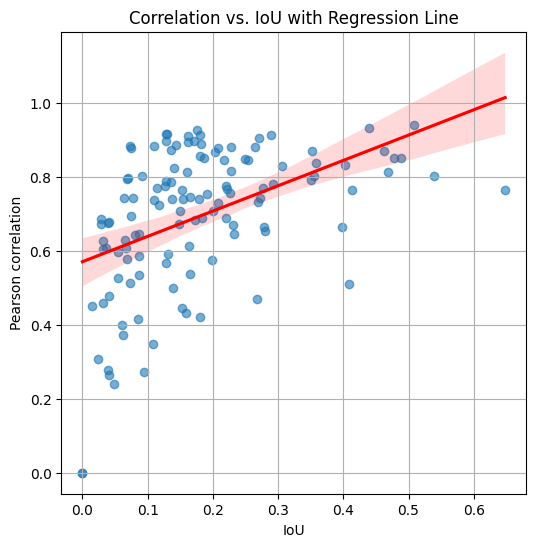

In [17]:
import seaborn as sns

# Prepare obs DataFrame as before
obs = sdata["table"].obs

plt.figure(figsize=(6, 6))
sns.regplot(
    data=obs,
    x="IoU",
    y="pearson_corr",
    scatter_kws={"alpha": 0.6},
    line_kws={"color": "red"},
    ci=95,
)
plt.xlabel("IoU")
plt.ylabel("Pearson correlation")
plt.title("Correlation vs. IoU with Regression Line")
plt.grid(True)
plt.show()

The histogram below shows the distribution of Pearson correlation values across cells. It is right-skewed, with a median of 0.74. This provides intuition about possible spatial spillover: cells may be contaminated by neighboring cells, assuming that nuclei capture expression with less contamination due to their smaller radius.

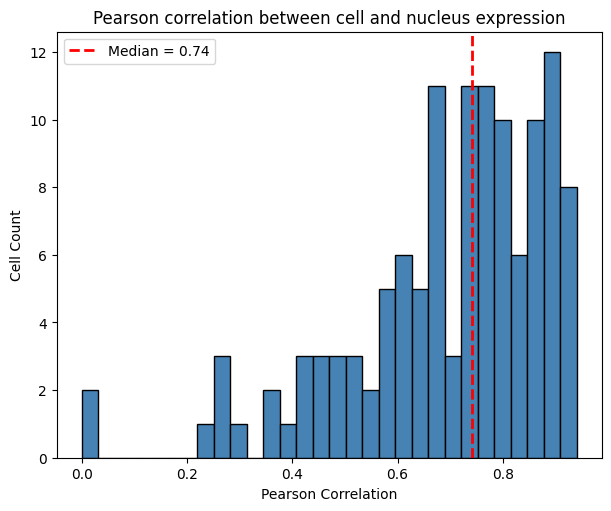

In [18]:
# Prepare IoU values
corr = obs["pearson_corr"]
median_corr = np.median(corr)

# Set up figure with histogram
fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)

# Plot histogram
ax.hist(corr, bins=30, color="steelblue", edgecolor="black")

# Add median line
ax.axvline(
    median_corr,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Median = {median_corr:.2f}",
)

# Decorate
ax.set_title("Pearson correlation between cell and nucleus expression")
ax.set_xlabel("Pearson Correlation")
ax.set_ylabel("Cell Count")
ax.legend()

plt.show()

The spatial plot below overlays nucleus boundaries, cell masks colored by Pearson correlation, and transcripts. Cells whose transcripts are distributed across the nucleus region tend to have higher correlation with the nucleus, while cells whose transcripts are localized outside the nuclear region—potentially due to spillover from neighboring cells—tend to exhibit lower correlation.

/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:511: UserWarning: Converting `region_key: region` to categorical dtype.
  convert_region_column_to_categorical(table)
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/pytho

INFO     input has more than 103 categories. Uniform 'grey' color will be used for all categories.                 


/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/spatialdata/_core/_elements.py:115: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:775: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to

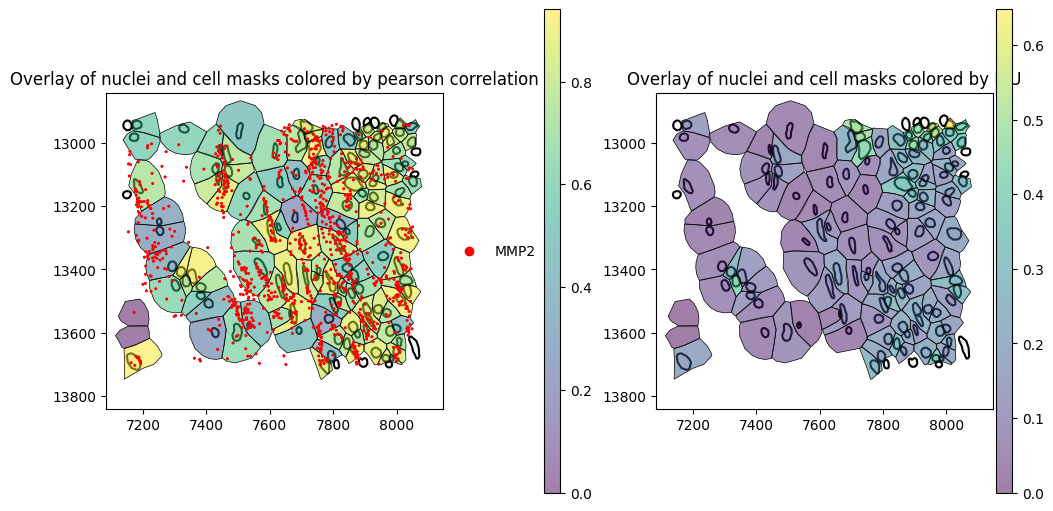

In [19]:
# link annotations with cell boundaries
sdata.tables["table"].obs["region"] = "cell_boundaries"
sdata.set_table_annotates_spatialelement("table", region="cell_boundaries")

axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)[1].flatten()

sdata.pl.render_shapes(
    element="nucleus_boundaries",
    fill_alpha=0.2,
    outline_alpha=1.0,
    outline_color="black",
).pl.render_shapes(
    element="cell_boundaries",
    color="pearson_corr",
    cmap="viridis",
    fill_alpha=0.5,
    outline_alpha=1.0,
    outline_width=0.5,
    outline_color="black",
).pl.render_points(
    "transcripts",
    color="feature_name",
    groups="MMP2",
    palette="red",
).pl.show(
    ax=axes[0],
    title="Overlay of nuclei and cell masks colored by pearson correlation",
    colorbar=True,
    figsize=(6, 6),
)


sdata.pl.render_shapes(
    element="nucleus_boundaries",
    fill_alpha=0.2,
    outline_alpha=1.0,
    outline_color="black",
).pl.render_shapes(
    element="cell_boundaries",
    color="IoU",
    cmap="viridis",
    fill_alpha=0.5,
    outline_alpha=1.0,
    outline_width=0.5,
    outline_color="black",
).pl.show(
    ax=axes[1],
    title="Overlay of nuclei and cell masks colored by IoU",
    colorbar=True,
    figsize=(6, 6),
)